In [2]:
%matplotlib inline

In [179]:
import os
import numpy as np
import nibabel as nib
import scipy.stats
from cmath import rect, phase
import matplotlib.pyplot as plt
from matplotlib import colors


In [114]:
def mean_angle(rad):
    return (phase(sum(rect(1, d) for d in rad)/float(len(rad))))

In [115]:
img = nib.load('brain.nii')
data = img.get_data()

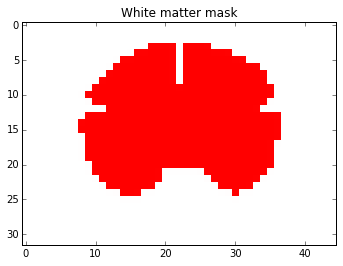

In [181]:
slice = data[:,28,:,0]

"""# XXX DUMMY SLICE

slice = np.zeros(slice.shape)
xx, yy = np.mgrid[:slice.shape[0], :slice.shape[1]]
x0, y0, radius = 15, 15, 10
circle = (xx - x0)**2 + (yy - y0)**2
slice = circle <= radius**2
slice = 255 * slice.astype(np.uint8)"""


plt.figure()
cmap = colors.ListedColormap(['white', 'red'])
plt.imshow(slice.T, interpolation='none', cmap=cmap)
plt.title("White matter mask")

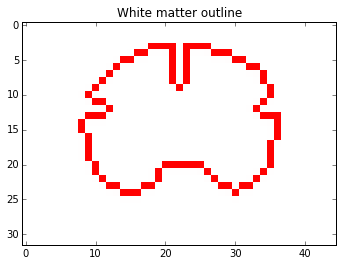

In [180]:
border  = np.zeros_like(slice)
for (i, j), val in np.ndenumerate(slice):
    if i > 0 and i < slice.shape[0] - 1 and j > 0 and j < slice.shape[1] - 1:
        if val > 0:
            if slice[i - 1, j] == 0 \
             or slice[i + 1, j] == 0 \
                or slice[i, j - 1] == 0 \
                or slice[i, j + 1] == 0:
                    border[i, j] = 1
                    
plt.figure()
plt.title("White matter outline")
cmap = colors.ListedColormap(['white', 'red'])
plt.imshow(border.T, interpolation='none', cmap=cmap)
                

In [165]:
idx = np.where(border)
n_idx = idx[0].size

In [175]:
n_particles = 50000
density = np.zeros_like(slice, dtype=np.float)
direction = np.zeros_like(slice, dtype=np.complex)   # N.B. direction is stored as complex numbers (vector representation in the complex plane) to facilitate averaging

for particle_idx in range(n_particles):
    if (particle_idx + 1) % 1000 == 0:
        print("Progress: " + str(particle_idx + 1) + " out of " + str(n_particles))
    start_voxel_idx = np.random.randint(n_idx)
    start_voxel = np.array([idx[0][start_voxel_idx], idx[1][start_voxel_idx]], dtype=np.int)
    direction_ang = scipy.stats.uniform(-np.pi, np.pi).rvs()
    direction_vector = np.array([np.cos(direction_ang), np.sin(direction_ang)])

    end_voxel = np.array(start_voxel + direction_vector * slice.shape[0] * slice.shape[1], dtype=np.int)
    
    #
    #   simulate particle trajectory
    #
    
    x0, y0, x1, y1 = start_voxel[0], start_voxel[1], end_voxel[0], end_voxel[1]
    
    steep = 0
    x = x0
    y = y0
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    if (x1 - x) > 0:
        sx = 1
    else:
        sx = -1
    if (y1 - y) > 0:
        sy = 1
    else:
        sy = -1

    if dy > dx:
        steep = 1
        x, y = y, x
        dx, dy = dy, dx
        sx, sy = sy, sx
    d = (2 * dy) - dx

    rr = -1 * np.ones(int(dx) + 1, dtype=np.intp)
    cc = -1 * np.ones(int(dx) + 1, dtype=np.intp)

    for i in range(dx):
        #print("Step"+ str(i))
        if steep:
            rr[i] = x
            cc[i] = y
        else:
            rr[i] = y
            cc[i] = x
        while d >= 0:
            y = y + sy
            d = d - (2 * dx)
        x = x + sx
        d = d + (2 * dy)
        
        if 0 <= cc[i] < slice.shape[0] and 0 <= rr[i] < slice.shape[1]:
            if slice[cc[i], rr[i]] == 0:
                cc[i] = -1
                rr[i] = -1
                break

    rr[dx] = y1
    cc[dx] = x1
    
    #
    #     plot the trajectory on the density & direction maps
    #
    
    for i in range(len(cc)):
        if 0 <= cc[i] < slice.shape[0] and 0 <= rr[i] < slice.shape[1] and not (cc[1] == -1):
            density[cc[i], rr[i]] += 1.
            if direction_ang < 0.:
                direction[cc[i], rr[i]] += rect(1, direction_ang + np.pi)
            else:
                direction[cc[i], rr[i]] += rect(1, direction_ang)
    
#
#   convert direction back from complex format to angle
#

direction_ang = np.empty_like(slice, dtype=np.float)
for (i, j), _ in np.ndenumerate(direction):
    direction_ang[i, j] = phase(direction[i, j])
    # density /= float(n_particles)

Progress: 1000 out of 50000
Progress: 2000 out of 50000
Progress: 3000 out of 50000
Progress: 4000 out of 50000
Progress: 5000 out of 50000
Progress: 6000 out of 50000
Progress: 7000 out of 50000
Progress: 8000 out of 50000
Progress: 9000 out of 50000
Progress: 10000 out of 50000
Progress: 11000 out of 50000
Progress: 12000 out of 50000
Progress: 13000 out of 50000
Progress: 14000 out of 50000
Progress: 15000 out of 50000
Progress: 16000 out of 50000
Progress: 17000 out of 50000
Progress: 18000 out of 50000
Progress: 19000 out of 50000
Progress: 20000 out of 50000
Progress: 21000 out of 50000
Progress: 22000 out of 50000
Progress: 23000 out of 50000
Progress: 24000 out of 50000
Progress: 25000 out of 50000
Progress: 26000 out of 50000
Progress: 27000 out of 50000
Progress: 28000 out of 50000
Progress: 29000 out of 50000
Progress: 30000 out of 50000
Progress: 31000 out of 50000
Progress: 32000 out of 50000
Progress: 33000 out of 50000
Progress: 34000 out of 50000
Progress: 35000 out of 

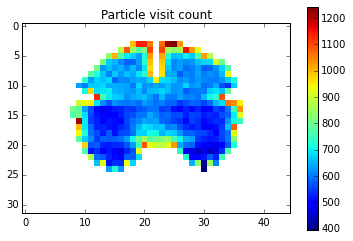

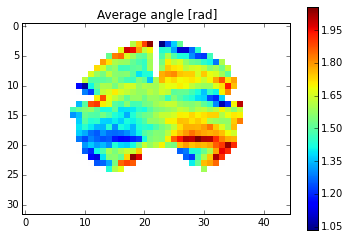

In [177]:
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

plt.figure()
masked_array = np.ma.array(density, mask=255 - slice)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Particle visit count")
plt.colorbar()

plt.figure()
masked_array = np.ma.array(direction_ang, mask=255 - slice)
plt.imshow(masked_array.T, interpolation='none', cmap=cmap)
plt.title("Average angle [rad]")
plt.colorbar()
